In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from BaselinePrerocess import baseline_process
from baselines.rnn import rnn

2023-07-23 21:00:29.397135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 21:00:30.919419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Preprocess

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


In [6]:
train_X_mask = train_X_mask[:, :n_hours, :]
val_X_mask = val_X_mask[:, :n_hours, :]
test_X_mask = test_X_mask[:, :n_hours, :]
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 72, 16) (9634, 72, 16) (19268, 72, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [7]:
# ===== model parameters ======
input_shape = train_X_mask.shape[1:]
rnn_unit1 = 64
rnn_unit2 = 32
rnn_unit3 = 16
l1_reg = 1e-5
l2_reg = 1e-5
dropout = 0.1
masked_value = 1e-10

learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

In [8]:
model = rnn(input_shape=input_shape,
            rnn_unit1=rnn_unit1,
            rnn_unit2=rnn_unit2,
            rnn_unit3=rnn_unit3,
            l1_reg=l1_reg, 
            l2_reg=l2_reg, 
            dropout=dropout,
            masked_value=masked_value
            )
model.summary()

2023-07-23 21:00:38.970800: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 16)]          0         
                                                                 
 masking (Masking)           (None, 72, 16)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 72, 64)            5184      
                                                                 
 dropout (Dropout)           (None, 72, 64)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 72, 32)            3104      
                                                                 
 dropout_1 (Dropout)         (None, 72, 32)            0         
                                                                 
 flatten (Flatten)           (None, 2304)              0     

In [9]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/rnn_gate_pump_nofuture.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit(train_X_mask, train_ws_y,
          validation_data=(test_X_mask, test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-23 21:00:47.686811: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fed8401a090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-23 21:00:47.686865: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-23 21:00:47.696921: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-23 21:00:47.928333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-23 21:00:48.299122: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.08875, saving model to saved_models/rnn_gate_pump_nofuture.h5
151/151 - 30s - loss: 0.0439 - mae: 0.1328 - val_loss: 0.0237 - val_mae: 0.0888 - 30s/epoch - 198ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.08875 to 0.06901, saving model to saved_models/rnn_gate_pump_nofuture.h5
151/151 - 24s - loss: 0.0188 - mae: 0.0706 - val_loss: 0.0181 - val_mae: 0.0690 - 24s/epoch - 157ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.06901 to 0.06278, saving model to saved_models/rnn_gate_pump_nofuture.h5
151/151 - 23s - loss: 0.0155 - mae: 0.0566 - val_loss: 0.0163 - val_mae: 0.0628 - 23s/epoch - 151ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.06278 to 0.06005, saving model to saved_models/rnn_gate_pump_nofuture.h5
151/151 - 24s - loss: 0.0138 - mae: 0.0493 - val_loss: 0.0154 - val_mae: 0.0601 - 24s/epoch - 156ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.06005 to 0.05666, saving model to saved_models/rnn_gate_pump_nofuture.h5
151/151 - 23s - loss: 0.0127 - mae: 0.0448 - val_loss: 0.0144 - val_mae: 0.0567 - 23s/epoch - 151ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.05666 to 0.05498, saving model to saved_models/rnn_gate_pump_nofut

Epoch 42/3000

Epoch 42: val_mae did not improve from 0.03874
151/151 - 23s - loss: 0.0031 - mae: 0.0257 - val_loss: 0.0044 - val_mae: 0.0395 - 23s/epoch - 154ms/step
Epoch 43/3000

Epoch 43: val_mae did not improve from 0.03874
151/151 - 23s - loss: 0.0030 - mae: 0.0256 - val_loss: 0.0042 - val_mae: 0.0389 - 23s/epoch - 154ms/step
Epoch 44/3000

Epoch 44: val_mae did not improve from 0.03874
151/151 - 24s - loss: 0.0029 - mae: 0.0255 - val_loss: 0.0041 - val_mae: 0.0388 - 24s/epoch - 156ms/step
Epoch 45/3000

Epoch 45: val_mae did not improve from 0.03874
151/151 - 23s - loss: 0.0028 - mae: 0.0254 - val_loss: 0.0041 - val_mae: 0.0395 - 23s/epoch - 155ms/step
Epoch 46/3000

Epoch 46: val_mae did not improve from 0.03874
151/151 - 24s - loss: 0.0027 - mae: 0.0253 - val_loss: 0.0039 - val_mae: 0.0389 - 24s/epoch - 160ms/step
Epoch 47/3000

Epoch 47: val_mae did not improve from 0.03874
151/151 - 24s - loss: 0.0026 - mae: 0.0251 - val_loss: 0.0039 - val_mae: 0.0392 - 24s/epoch - 158ms/ste

Epoch 88/3000

Epoch 88: val_mae improved from 0.03661 to 0.03652, saving model to saved_models/rnn_gate_pump_nofuture.h5
151/151 - 23s - loss: 0.0013 - mae: 0.0224 - val_loss: 0.0025 - val_mae: 0.0365 - 23s/epoch - 151ms/step
Epoch 89/3000

Epoch 89: val_mae did not improve from 0.03652
151/151 - 22s - loss: 0.0013 - mae: 0.0223 - val_loss: 0.0025 - val_mae: 0.0368 - 22s/epoch - 148ms/step
Epoch 90/3000

Epoch 90: val_mae did not improve from 0.03652
151/151 - 23s - loss: 0.0013 - mae: 0.0224 - val_loss: 0.0025 - val_mae: 0.0369 - 23s/epoch - 150ms/step
Epoch 91/3000

Epoch 91: val_mae did not improve from 0.03652
151/151 - 23s - loss: 0.0013 - mae: 0.0223 - val_loss: 0.0025 - val_mae: 0.0367 - 23s/epoch - 153ms/step
Epoch 92/3000

Epoch 92: val_mae improved from 0.03652 to 0.03638, saving model to saved_models/rnn_gate_pump_nofuture.h5
151/151 - 24s - loss: 0.0013 - mae: 0.0223 - val_loss: 0.0024 - val_mae: 0.0364 - 24s/epoch - 156ms/step
Epoch 93/3000

Epoch 93: val_mae did not impr

151/151 - 23s - loss: 0.0011 - mae: 0.0219 - val_loss: 0.0023 - val_mae: 0.0364 - 23s/epoch - 153ms/step
Epoch 136/3000

Epoch 136: val_mae improved from 0.03602 to 0.03598, saving model to saved_models/rnn_gate_pump_nofuture.h5
151/151 - 23s - loss: 0.0011 - mae: 0.0219 - val_loss: 0.0023 - val_mae: 0.0360 - 23s/epoch - 155ms/step
Epoch 137/3000

Epoch 137: val_mae did not improve from 0.03598
151/151 - 23s - loss: 0.0011 - mae: 0.0219 - val_loss: 0.0023 - val_mae: 0.0362 - 23s/epoch - 155ms/step
Epoch 138/3000

Epoch 138: val_mae did not improve from 0.03598
151/151 - 23s - loss: 0.0011 - mae: 0.0218 - val_loss: 0.0023 - val_mae: 0.0362 - 23s/epoch - 152ms/step
Epoch 139/3000

Epoch 139: val_mae did not improve from 0.03598
151/151 - 23s - loss: 0.0011 - mae: 0.0218 - val_loss: 0.0023 - val_mae: 0.0365 - 23s/epoch - 150ms/step
Epoch 140/3000

Epoch 140: val_mae did not improve from 0.03598
151/151 - 23s - loss: 0.0011 - mae: 0.0218 - val_loss: 0.0023 - val_mae: 0.0363 - 23s/epoch - 1

Epoch 183/3000

Epoch 183: val_mae did not improve from 0.03573
151/151 - 23s - loss: 0.0010 - mae: 0.0216 - val_loss: 0.0022 - val_mae: 0.0358 - 23s/epoch - 152ms/step
Epoch 184/3000

Epoch 184: val_mae did not improve from 0.03573
151/151 - 23s - loss: 0.0010 - mae: 0.0216 - val_loss: 0.0023 - val_mae: 0.0364 - 23s/epoch - 155ms/step
Epoch 185/3000

Epoch 185: val_mae did not improve from 0.03573
151/151 - 24s - loss: 0.0010 - mae: 0.0216 - val_loss: 0.0022 - val_mae: 0.0361 - 24s/epoch - 161ms/step
Epoch 186/3000

Epoch 186: val_mae did not improve from 0.03573
151/151 - 23s - loss: 0.0010 - mae: 0.0216 - val_loss: 0.0022 - val_mae: 0.0359 - 23s/epoch - 154ms/step
Epoch 187/3000

Epoch 187: val_mae did not improve from 0.03573
151/151 - 23s - loss: 0.0010 - mae: 0.0215 - val_loss: 0.0022 - val_mae: 0.0360 - 23s/epoch - 155ms/step
Epoch 188/3000

Epoch 188: val_mae did not improve from 0.03573
151/151 - 23s - loss: 0.0010 - mae: 0.0216 - val_loss: 0.0022 - val_mae: 0.0359 - 23s/epoch


Epoch 230: val_mae did not improve from 0.03545
151/151 - 23s - loss: 9.8904e-04 - mae: 0.0214 - val_loss: 0.0022 - val_mae: 0.0357 - 23s/epoch - 151ms/step
Epoch 231/3000

Epoch 231: val_mae did not improve from 0.03545
151/151 - 23s - loss: 9.8723e-04 - mae: 0.0214 - val_loss: 0.0022 - val_mae: 0.0358 - 23s/epoch - 150ms/step
Epoch 232/3000

Epoch 232: val_mae did not improve from 0.03545
151/151 - 24s - loss: 9.8961e-04 - mae: 0.0214 - val_loss: 0.0022 - val_mae: 0.0357 - 24s/epoch - 157ms/step
Epoch 233/3000

Epoch 233: val_mae did not improve from 0.03545
151/151 - 23s - loss: 9.8707e-04 - mae: 0.0214 - val_loss: 0.0022 - val_mae: 0.0357 - 23s/epoch - 150ms/step
Epoch 234/3000

Epoch 234: val_mae did not improve from 0.03545
151/151 - 23s - loss: 9.8658e-04 - mae: 0.0214 - val_loss: 0.0022 - val_mae: 0.0361 - 23s/epoch - 152ms/step
Epoch 235/3000

Epoch 235: val_mae did not improve from 0.03545
151/151 - 23s - loss: 9.8926e-04 - mae: 0.0214 - val_loss: 0.0022 - val_mae: 0.0357 - 

Epoch 277/3000

Epoch 277: val_mae did not improve from 0.03532
151/151 - 23s - loss: 9.6903e-04 - mae: 0.0213 - val_loss: 0.0021 - val_mae: 0.0355 - 23s/epoch - 151ms/step
Epoch 278/3000

Epoch 278: val_mae did not improve from 0.03532
151/151 - 23s - loss: 9.6748e-04 - mae: 0.0213 - val_loss: 0.0021 - val_mae: 0.0357 - 23s/epoch - 153ms/step
Epoch 279/3000

Epoch 279: val_mae did not improve from 0.03532
151/151 - 23s - loss: 9.6707e-04 - mae: 0.0213 - val_loss: 0.0021 - val_mae: 0.0355 - 23s/epoch - 151ms/step
Epoch 280/3000

Epoch 280: val_mae did not improve from 0.03532
151/151 - 23s - loss: 9.6584e-04 - mae: 0.0213 - val_loss: 0.0021 - val_mae: 0.0354 - 23s/epoch - 154ms/step
Epoch 281/3000

Epoch 281: val_mae did not improve from 0.03532
151/151 - 23s - loss: 9.6699e-04 - mae: 0.0213 - val_loss: 0.0022 - val_mae: 0.0360 - 23s/epoch - 152ms/step
Epoch 282/3000

Epoch 282: val_mae did not improve from 0.03532
151/151 - 23s - loss: 9.6635e-04 - mae: 0.0213 - val_loss: 0.0022 - val

151/151 - 23s - loss: 9.5008e-04 - mae: 0.0212 - val_loss: 0.0022 - val_mae: 0.0358 - 23s/epoch - 151ms/step
Epoch 325/3000

Epoch 325: val_mae did not improve from 0.03532
151/151 - 24s - loss: 9.5206e-04 - mae: 0.0212 - val_loss: 0.0022 - val_mae: 0.0360 - 24s/epoch - 156ms/step
Epoch 326/3000

Epoch 326: val_mae did not improve from 0.03532
151/151 - 23s - loss: 9.5072e-04 - mae: 0.0212 - val_loss: 0.0022 - val_mae: 0.0358 - 23s/epoch - 153ms/step
Epoch 327/3000

Epoch 327: val_mae did not improve from 0.03532
151/151 - 23s - loss: 9.5062e-04 - mae: 0.0212 - val_loss: 0.0021 - val_mae: 0.0355 - 23s/epoch - 152ms/step
Epoch 328/3000

Epoch 328: val_mae did not improve from 0.03532
151/151 - 23s - loss: 9.4956e-04 - mae: 0.0212 - val_loss: 0.0021 - val_mae: 0.0357 - 23s/epoch - 153ms/step
Epoch 329/3000

Epoch 329: val_mae did not improve from 0.03532
151/151 - 23s - loss: 9.5010e-04 - mae: 0.0212 - val_loss: 0.0021 - val_mae: 0.0355 - 23s/epoch - 151ms/step
Epoch 330/3000

Epoch 330:

Epoch 371/3000

Epoch 371: val_mae did not improve from 0.03517
151/151 - 23s - loss: 9.4066e-04 - mae: 0.0211 - val_loss: 0.0021 - val_mae: 0.0355 - 23s/epoch - 155ms/step
Epoch 372/3000

Epoch 372: val_mae did not improve from 0.03517
151/151 - 23s - loss: 9.4010e-04 - mae: 0.0211 - val_loss: 0.0021 - val_mae: 0.0356 - 23s/epoch - 156ms/step
Epoch 373/3000

Epoch 373: val_mae did not improve from 0.03517
151/151 - 24s - loss: 9.3862e-04 - mae: 0.0211 - val_loss: 0.0021 - val_mae: 0.0354 - 24s/epoch - 159ms/step
Epoch 374/3000

Epoch 374: val_mae did not improve from 0.03517
151/151 - 23s - loss: 9.4127e-04 - mae: 0.0212 - val_loss: 0.0022 - val_mae: 0.0360 - 23s/epoch - 154ms/step
Epoch 375/3000

Epoch 375: val_mae did not improve from 0.03517
151/151 - 24s - loss: 9.3850e-04 - mae: 0.0211 - val_loss: 0.0021 - val_mae: 0.0355 - 24s/epoch - 156ms/step
Epoch 376/3000

Epoch 376: val_mae did not improve from 0.03517
151/151 - 23s - loss: 9.4083e-04 - mae: 0.0211 - val_loss: 0.0021 - val

151/151 - 23s - loss: 9.3139e-04 - mae: 0.0211 - val_loss: 0.0021 - val_mae: 0.0353 - 23s/epoch - 151ms/step
Epoch 419/3000

Epoch 419: val_mae did not improve from 0.03517
151/151 - 23s - loss: 9.3058e-04 - mae: 0.0211 - val_loss: 0.0021 - val_mae: 0.0355 - 23s/epoch - 151ms/step
Epoch 420/3000

Epoch 420: val_mae did not improve from 0.03517
151/151 - 23s - loss: 9.3100e-04 - mae: 0.0211 - val_loss: 0.0021 - val_mae: 0.0355 - 23s/epoch - 153ms/step
Epoch 421/3000

Epoch 421: val_mae did not improve from 0.03517
151/151 - 23s - loss: 9.3204e-04 - mae: 0.0211 - val_loss: 0.0021 - val_mae: 0.0354 - 23s/epoch - 153ms/step
Epoch 422/3000

Epoch 422: val_mae did not improve from 0.03517
151/151 - 24s - loss: 9.2986e-04 - mae: 0.0210 - val_loss: 0.0021 - val_mae: 0.0356 - 24s/epoch - 157ms/step
Epoch 423/3000

Epoch 423: val_mae did not improve from 0.03517
151/151 - 23s - loss: 9.3133e-04 - mae: 0.0211 - val_loss: 0.0021 - val_mae: 0.0354 - 23s/epoch - 153ms/step
Epoch 424/3000

Epoch 424:

Epoch 465/3000

Epoch 465: val_mae did not improve from 0.03509
151/151 - 24s - loss: 9.2479e-04 - mae: 0.0210 - val_loss: 0.0021 - val_mae: 0.0354 - 24s/epoch - 156ms/step
Epoch 466/3000

Epoch 466: val_mae did not improve from 0.03509
151/151 - 23s - loss: 9.2583e-04 - mae: 0.0210 - val_loss: 0.0021 - val_mae: 0.0354 - 23s/epoch - 155ms/step
Epoch 467/3000

Epoch 467: val_mae did not improve from 0.03509
151/151 - 23s - loss: 9.2537e-04 - mae: 0.0210 - val_loss: 0.0021 - val_mae: 0.0352 - 23s/epoch - 152ms/step
Epoch 468/3000

Epoch 468: val_mae did not improve from 0.03509
151/151 - 23s - loss: 9.2562e-04 - mae: 0.0210 - val_loss: 0.0021 - val_mae: 0.0355 - 23s/epoch - 154ms/step
Epoch 469/3000

Epoch 469: val_mae did not improve from 0.03509
151/151 - 23s - loss: 9.2393e-04 - mae: 0.0210 - val_loss: 0.0021 - val_mae: 0.0351 - 23s/epoch - 155ms/step
Epoch 470/3000

Epoch 470: val_mae did not improve from 0.03509
151/151 - 23s - loss: 9.2416e-04 - mae: 0.0210 - val_loss: 0.0021 - val

151/151 - 23s - loss: 9.1958e-04 - mae: 0.0210 - val_loss: 0.0021 - val_mae: 0.0353 - 23s/epoch - 153ms/step
Epoch 512/3000

Epoch 512: val_mae did not improve from 0.03488
151/151 - 23s - loss: 9.2017e-04 - mae: 0.0210 - val_loss: 0.0021 - val_mae: 0.0352 - 23s/epoch - 153ms/step
Epoch 513/3000

Epoch 513: val_mae did not improve from 0.03488
151/151 - 23s - loss: 9.1821e-04 - mae: 0.0210 - val_loss: 0.0021 - val_mae: 0.0352 - 23s/epoch - 154ms/step
Epoch 514/3000

Epoch 514: val_mae did not improve from 0.03488
151/151 - 23s - loss: 9.2006e-04 - mae: 0.0210 - val_loss: 0.0021 - val_mae: 0.0353 - 23s/epoch - 150ms/step
Epoch 515/3000

Epoch 515: val_mae did not improve from 0.03488
151/151 - 24s - loss: 9.2273e-04 - mae: 0.0210 - val_loss: 0.0021 - val_mae: 0.0355 - 24s/epoch - 157ms/step
Epoch 516/3000

Epoch 516: val_mae did not improve from 0.03488
151/151 - 23s - loss: 9.2189e-04 - mae: 0.0210 - val_loss: 0.0020 - val_mae: 0.0350 - 23s/epoch - 153ms/step
Epoch 517/3000

Epoch 517:

Epoch 558/3000

Epoch 558: val_mae did not improve from 0.03461
151/151 - 24s - loss: 9.1633e-04 - mae: 0.0210 - val_loss: 0.0020 - val_mae: 0.0349 - 24s/epoch - 156ms/step
Epoch 559/3000

Epoch 559: val_mae did not improve from 0.03461
151/151 - 23s - loss: 9.1417e-04 - mae: 0.0210 - val_loss: 0.0021 - val_mae: 0.0352 - 23s/epoch - 151ms/step
Epoch 560/3000

Epoch 560: val_mae did not improve from 0.03461
151/151 - 24s - loss: 9.1658e-04 - mae: 0.0210 - val_loss: 0.0020 - val_mae: 0.0348 - 24s/epoch - 156ms/step
Epoch 561/3000

Epoch 561: val_mae did not improve from 0.03461
151/151 - 24s - loss: 9.1436e-04 - mae: 0.0210 - val_loss: 0.0020 - val_mae: 0.0348 - 24s/epoch - 160ms/step
Epoch 562/3000

Epoch 562: val_mae did not improve from 0.03461
151/151 - 23s - loss: 9.1630e-04 - mae: 0.0210 - val_loss: 0.0020 - val_mae: 0.0348 - 23s/epoch - 153ms/step
Epoch 563/3000

Epoch 563: val_mae did not improve from 0.03461
151/151 - 24s - loss: 9.1613e-04 - mae: 0.0210 - val_loss: 0.0020 - val

151/151 - 23s - loss: 9.1172e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0349 - 23s/epoch - 153ms/step
Epoch 605/3000

Epoch 605: val_mae did not improve from 0.03448
151/151 - 23s - loss: 9.1310e-04 - mae: 0.0210 - val_loss: 0.0020 - val_mae: 0.0348 - 23s/epoch - 154ms/step
Epoch 606/3000

Epoch 606: val_mae did not improve from 0.03448
151/151 - 23s - loss: 9.1328e-04 - mae: 0.0210 - val_loss: 0.0020 - val_mae: 0.0350 - 23s/epoch - 150ms/step
Epoch 607/3000

Epoch 607: val_mae did not improve from 0.03448
151/151 - 23s - loss: 9.1137e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0347 - 23s/epoch - 152ms/step
Epoch 608/3000

Epoch 608: val_mae did not improve from 0.03448
151/151 - 23s - loss: 9.1108e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0347 - 23s/epoch - 153ms/step
Epoch 609/3000

Epoch 609: val_mae did not improve from 0.03448
151/151 - 23s - loss: 9.1155e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0346 - 23s/epoch - 153ms/step
Epoch 610/3000

Epoch 610:

Epoch 652/3000

Epoch 652: val_mae did not improve from 0.03445
151/151 - 23s - loss: 9.1293e-04 - mae: 0.0210 - val_loss: 0.0020 - val_mae: 0.0349 - 23s/epoch - 154ms/step
Epoch 653/3000

Epoch 653: val_mae improved from 0.03445 to 0.03431, saving model to saved_models/rnn_gate_pump_nofuture.h5
151/151 - 23s - loss: 9.0842e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0343 - 23s/epoch - 155ms/step
Epoch 654/3000

Epoch 654: val_mae did not improve from 0.03431
151/151 - 23s - loss: 9.0950e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0345 - 23s/epoch - 155ms/step
Epoch 655/3000

Epoch 655: val_mae did not improve from 0.03431
151/151 - 24s - loss: 9.0803e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0345 - 24s/epoch - 158ms/step
Epoch 656/3000

Epoch 656: val_mae did not improve from 0.03431
151/151 - 24s - loss: 9.0910e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0345 - 24s/epoch - 157ms/step
Epoch 657/3000

Epoch 657: val_mae did not improve from 0.03431
151/151 - 2

Epoch 699/3000

Epoch 699: val_mae did not improve from 0.03427
151/151 - 23s - loss: 9.0561e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0347 - 23s/epoch - 154ms/step
Epoch 700/3000

Epoch 700: val_mae did not improve from 0.03427
151/151 - 23s - loss: 9.0642e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0346 - 23s/epoch - 151ms/step
Epoch 701/3000

Epoch 701: val_mae did not improve from 0.03427
151/151 - 23s - loss: 9.0637e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0343 - 23s/epoch - 155ms/step
Epoch 702/3000

Epoch 702: val_mae did not improve from 0.03427
151/151 - 23s - loss: 9.0630e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0345 - 23s/epoch - 154ms/step
Epoch 703/3000

Epoch 703: val_mae did not improve from 0.03427
151/151 - 23s - loss: 9.0692e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0345 - 23s/epoch - 149ms/step
Epoch 704/3000

Epoch 704: val_mae did not improve from 0.03427
151/151 - 23s - loss: 9.0684e-04 - mae: 0.0209 - val_loss: 0.0020 - val

Epoch 746/3000

Epoch 746: val_mae did not improve from 0.03416
151/151 - 23s - loss: 9.0526e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0344 - 23s/epoch - 153ms/step
Epoch 747/3000

Epoch 747: val_mae did not improve from 0.03416
151/151 - 23s - loss: 9.0301e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0344 - 23s/epoch - 155ms/step
Epoch 748/3000

Epoch 748: val_mae did not improve from 0.03416
151/151 - 23s - loss: 9.0300e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0343 - 23s/epoch - 150ms/step
Epoch 749/3000

Epoch 749: val_mae did not improve from 0.03416
151/151 - 23s - loss: 9.0512e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0344 - 23s/epoch - 151ms/step
Epoch 750/3000

Epoch 750: val_mae did not improve from 0.03416
151/151 - 23s - loss: 9.0240e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0344 - 23s/epoch - 151ms/step
Epoch 751/3000

Epoch 751: val_mae did not improve from 0.03416
151/151 - 22s - loss: 9.0269e-04 - mae: 0.0209 - val_loss: 0.0020 - val

Epoch 792/3000

Epoch 792: val_mae did not improve from 0.03402
151/151 - 23s - loss: 9.0071e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0344 - 23s/epoch - 152ms/step
Epoch 793/3000

Epoch 793: val_mae did not improve from 0.03402
151/151 - 23s - loss: 9.0191e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0343 - 23s/epoch - 155ms/step
Epoch 794/3000

Epoch 794: val_mae did not improve from 0.03402
151/151 - 24s - loss: 9.0043e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0342 - 24s/epoch - 159ms/step
Epoch 795/3000

Epoch 795: val_mae did not improve from 0.03402
151/151 - 23s - loss: 9.0184e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0344 - 23s/epoch - 153ms/step
Epoch 796/3000

Epoch 796: val_mae did not improve from 0.03402
151/151 - 24s - loss: 9.0210e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0342 - 24s/epoch - 158ms/step
Epoch 797/3000

Epoch 797: val_mae did not improve from 0.03402
151/151 - 23s - loss: 9.0004e-04 - mae: 0.0209 - val_loss: 0.0020 - val


Epoch 839: val_mae did not improve from 0.03397
151/151 - 23s - loss: 8.9866e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0343 - 23s/epoch - 155ms/step
Epoch 840/3000

Epoch 840: val_mae did not improve from 0.03397
151/151 - 23s - loss: 8.9865e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0343 - 23s/epoch - 152ms/step
Epoch 841/3000

Epoch 841: val_mae did not improve from 0.03397
151/151 - 23s - loss: 9.0074e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0344 - 23s/epoch - 151ms/step
Epoch 842/3000

Epoch 842: val_mae did not improve from 0.03397
151/151 - 23s - loss: 9.0098e-04 - mae: 0.0209 - val_loss: 0.0019 - val_mae: 0.0341 - 23s/epoch - 153ms/step
Epoch 843/3000

Epoch 843: val_mae did not improve from 0.03397
151/151 - 23s - loss: 8.9888e-04 - mae: 0.0209 - val_loss: 0.0019 - val_mae: 0.0340 - 23s/epoch - 151ms/step
Epoch 844/3000

Epoch 844: val_mae did not improve from 0.03397
151/151 - 23s - loss: 8.9918e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0342 - 

151/151 - 23s - loss: 8.9546e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0342 - 23s/epoch - 149ms/step
Epoch 887/3000

Epoch 887: val_mae did not improve from 0.03386
151/151 - 23s - loss: 8.9576e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0342 - 23s/epoch - 151ms/step
Epoch 888/3000

Epoch 888: val_mae did not improve from 0.03386
151/151 - 22s - loss: 8.9754e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0343 - 22s/epoch - 148ms/step
Epoch 889/3000

Epoch 889: val_mae did not improve from 0.03386
151/151 - 23s - loss: 8.9628e-04 - mae: 0.0209 - val_loss: 0.0019 - val_mae: 0.0342 - 23s/epoch - 151ms/step
Epoch 890/3000

Epoch 890: val_mae did not improve from 0.03386
151/151 - 24s - loss: 8.9774e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0345 - 24s/epoch - 158ms/step
Epoch 891/3000

Epoch 891: val_mae did not improve from 0.03386
151/151 - 23s - loss: 8.9584e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0342 - 23s/epoch - 151ms/step
Epoch 892/3000

Epoch 892:


Epoch 933: val_mae did not improve from 0.03378
151/151 - 23s - loss: 8.9478e-04 - mae: 0.0209 - val_loss: 0.0019 - val_mae: 0.0342 - 23s/epoch - 152ms/step
Epoch 934/3000

Epoch 934: val_mae did not improve from 0.03378
151/151 - 23s - loss: 8.9469e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0341 - 23s/epoch - 151ms/step
Epoch 935/3000

Epoch 935: val_mae did not improve from 0.03378
151/151 - 24s - loss: 8.9922e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0343 - 24s/epoch - 158ms/step
Epoch 936/3000

Epoch 936: val_mae did not improve from 0.03378
151/151 - 23s - loss: 8.9590e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0341 - 23s/epoch - 155ms/step
Epoch 937/3000

Epoch 937: val_mae did not improve from 0.03378
151/151 - 23s - loss: 8.9629e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0343 - 23s/epoch - 152ms/step
Epoch 938/3000

Epoch 938: val_mae did not improve from 0.03378
151/151 - 23s - loss: 8.9525e-04 - mae: 0.0209 - val_loss: 0.0019 - val_mae: 0.0342 - 

Epoch 981/3000

Epoch 981: val_mae did not improve from 0.03378
151/151 - 23s - loss: 8.9047e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0338 - 23s/epoch - 150ms/step
Epoch 982/3000

Epoch 982: val_mae did not improve from 0.03378
151/151 - 23s - loss: 8.9398e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0341 - 23s/epoch - 150ms/step
Epoch 983/3000

Epoch 983: val_mae did not improve from 0.03378
151/151 - 24s - loss: 8.9421e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0340 - 24s/epoch - 157ms/step
Epoch 984/3000

Epoch 984: val_mae did not improve from 0.03378
151/151 - 24s - loss: 8.9381e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0341 - 24s/epoch - 156ms/step
Epoch 985/3000

Epoch 985: val_mae did not improve from 0.03378
151/151 - 23s - loss: 8.9431e-04 - mae: 0.0208 - val_loss: 0.0020 - val_mae: 0.0344 - 23s/epoch - 153ms/step
Epoch 986/3000

Epoch 986: val_mae did not improve from 0.03378
151/151 - 22s - loss: 8.9267e-04 - mae: 0.0208 - val_loss: 0.0019 - val

Epoch 1028/3000

Epoch 1028: val_mae did not improve from 0.03371
151/151 - 23s - loss: 8.9198e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0342 - 23s/epoch - 154ms/step
Epoch 1029/3000

Epoch 1029: val_mae did not improve from 0.03371
151/151 - 23s - loss: 8.9069e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0339 - 23s/epoch - 156ms/step
Epoch 1030/3000

Epoch 1030: val_mae did not improve from 0.03371
151/151 - 24s - loss: 8.9289e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0339 - 24s/epoch - 158ms/step
Epoch 1031/3000

Epoch 1031: val_mae did not improve from 0.03371
151/151 - 23s - loss: 8.9264e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0341 - 23s/epoch - 156ms/step
Epoch 1032/3000

Epoch 1032: val_mae did not improve from 0.03371
151/151 - 24s - loss: 8.9203e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0340 - 24s/epoch - 159ms/step
Epoch 1033/3000

Epoch 1033: val_mae did not improve from 0.03371
151/151 - 23s - loss: 8.9244e-04 - mae: 0.0208 - val_loss: 

Epoch 1075/3000

Epoch 1075: val_mae did not improve from 0.03366
151/151 - 23s - loss: 8.8923e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0340 - 23s/epoch - 150ms/step
Epoch 1076/3000

Epoch 1076: val_mae did not improve from 0.03366
151/151 - 23s - loss: 8.9147e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0339 - 23s/epoch - 153ms/step
Epoch 1077/3000

Epoch 1077: val_mae did not improve from 0.03366
151/151 - 23s - loss: 8.9269e-04 - mae: 0.0208 - val_loss: 0.0020 - val_mae: 0.0343 - 23s/epoch - 153ms/step
Epoch 1078/3000

Epoch 1078: val_mae did not improve from 0.03366
151/151 - 23s - loss: 8.8871e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0339 - 23s/epoch - 150ms/step
Epoch 1079/3000

Epoch 1079: val_mae improved from 0.03366 to 0.03360, saving model to saved_models/rnn_gate_pump_nofuture.h5
151/151 - 23s - loss: 8.8938e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0336 - 23s/epoch - 150ms/step
Epoch 1080/3000

Epoch 1080: val_mae did not improve from 0.03360

151/151 - 23s - loss: 8.8966e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0339 - 23s/epoch - 153ms/step
Epoch 1122/3000

Epoch 1122: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8899e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0337 - 23s/epoch - 149ms/step
Epoch 1123/3000

Epoch 1123: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8935e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0341 - 23s/epoch - 152ms/step
Epoch 1124/3000

Epoch 1124: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8924e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0339 - 23s/epoch - 156ms/step
Epoch 1125/3000

Epoch 1125: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8767e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0341 - 23s/epoch - 151ms/step
Epoch 1126/3000

Epoch 1126: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8947e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0337 - 23s/epoch - 154ms/step
Epoch 1127/3000


151/151 - 23s - loss: 8.8744e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0339 - 23s/epoch - 152ms/step
Epoch 1169/3000

Epoch 1169: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8728e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0335 - 23s/epoch - 152ms/step
Epoch 1170/3000

Epoch 1170: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8721e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0336 - 23s/epoch - 154ms/step
Epoch 1171/3000

Epoch 1171: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8821e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0341 - 23s/epoch - 154ms/step
Epoch 1172/3000

Epoch 1172: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8662e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0339 - 23s/epoch - 152ms/step
Epoch 1173/3000

Epoch 1173: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8723e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0336 - 23s/epoch - 154ms/step
Epoch 1174/3000


151/151 - 23s - loss: 8.8730e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0338 - 23s/epoch - 154ms/step
Epoch 1216/3000

Epoch 1216: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8652e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0336 - 23s/epoch - 152ms/step
Epoch 1217/3000

Epoch 1217: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8682e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0338 - 23s/epoch - 152ms/step
Epoch 1218/3000

Epoch 1218: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8742e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0338 - 23s/epoch - 153ms/step
Epoch 1219/3000

Epoch 1219: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8536e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0337 - 23s/epoch - 152ms/step
Epoch 1220/3000

Epoch 1220: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8702e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0337 - 23s/epoch - 151ms/step
Epoch 1221/3000


151/151 - 23s - loss: 8.8490e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0334 - 23s/epoch - 149ms/step
Epoch 1263/3000

Epoch 1263: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8574e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0338 - 23s/epoch - 152ms/step
Epoch 1264/3000

Epoch 1264: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8325e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0339 - 23s/epoch - 151ms/step
Epoch 1265/3000

Epoch 1265: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8509e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0337 - 23s/epoch - 150ms/step
Epoch 1266/3000

Epoch 1266: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8449e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0340 - 23s/epoch - 151ms/step
Epoch 1267/3000

Epoch 1267: val_mae did not improve from 0.03340
151/151 - 23s - loss: 8.8447e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0335 - 23s/epoch - 151ms/step
Epoch 1268/3000


151/151 - 23s - loss: 8.8394e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0334 - 23s/epoch - 155ms/step
Epoch 1309/3000

Epoch 1309: val_mae did not improve from 0.03331
151/151 - 23s - loss: 8.8636e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0338 - 23s/epoch - 155ms/step
Epoch 1310/3000

Epoch 1310: val_mae did not improve from 0.03331
151/151 - 23s - loss: 8.8668e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0337 - 23s/epoch - 150ms/step
Epoch 1311/3000

Epoch 1311: val_mae did not improve from 0.03331
151/151 - 23s - loss: 8.8550e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0335 - 23s/epoch - 150ms/step
Epoch 1312/3000

Epoch 1312: val_mae did not improve from 0.03331
151/151 - 23s - loss: 8.8471e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0335 - 23s/epoch - 152ms/step
Epoch 1313/3000

Epoch 1313: val_mae did not improve from 0.03331
151/151 - 23s - loss: 8.8389e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0336 - 23s/epoch - 155ms/step
Epoch 1314/3000


151/151 - 23s - loss: 8.8504e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0336 - 23s/epoch - 151ms/step
Epoch 1355/3000

Epoch 1355: val_mae did not improve from 0.03303
151/151 - 23s - loss: 8.8357e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0334 - 23s/epoch - 153ms/step
Epoch 1356/3000

Epoch 1356: val_mae did not improve from 0.03303
151/151 - 23s - loss: 8.8462e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0335 - 23s/epoch - 151ms/step
Epoch 1357/3000

Epoch 1357: val_mae did not improve from 0.03303
151/151 - 23s - loss: 8.8244e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0337 - 23s/epoch - 152ms/step
Epoch 1358/3000

Epoch 1358: val_mae did not improve from 0.03303
151/151 - 23s - loss: 8.8410e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0337 - 23s/epoch - 150ms/step
Epoch 1359/3000

Epoch 1359: val_mae did not improve from 0.03303
151/151 - 23s - loss: 8.8231e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0334 - 23s/epoch - 151ms/step
Epoch 1360/3000


Epoch 1401/3000

Epoch 1401: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.8244e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0333 - 23s/epoch - 151ms/step
Epoch 1402/3000

Epoch 1402: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.8310e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0336 - 23s/epoch - 151ms/step
Epoch 1403/3000

Epoch 1403: val_mae did not improve from 0.03292
151/151 - 24s - loss: 8.8454e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0334 - 24s/epoch - 156ms/step
Epoch 1404/3000

Epoch 1404: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.8270e-04 - mae: 0.0208 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 155ms/step
Epoch 1405/3000

Epoch 1405: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.8391e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0333 - 23s/epoch - 153ms/step
Epoch 1406/3000

Epoch 1406: val_mae did not improve from 0.03292
151/151 - 24s - loss: 8.8279e-04 - mae: 0.0208 - val_loss: 

Epoch 1448/3000

Epoch 1448: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.8137e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0335 - 23s/epoch - 155ms/step
Epoch 1449/3000

Epoch 1449: val_mae did not improve from 0.03292
151/151 - 24s - loss: 8.8082e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0333 - 24s/epoch - 156ms/step
Epoch 1450/3000

Epoch 1450: val_mae did not improve from 0.03292
151/151 - 24s - loss: 8.8174e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0332 - 24s/epoch - 159ms/step
Epoch 1451/3000

Epoch 1451: val_mae did not improve from 0.03292
151/151 - 24s - loss: 8.8243e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0332 - 24s/epoch - 157ms/step
Epoch 1452/3000

Epoch 1452: val_mae did not improve from 0.03292
151/151 - 24s - loss: 8.8269e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0334 - 24s/epoch - 156ms/step
Epoch 1453/3000

Epoch 1453: val_mae did not improve from 0.03292
151/151 - 24s - loss: 8.8222e-04 - mae: 0.0208 - val_loss: 

Epoch 1495/3000

Epoch 1495: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.8171e-04 - mae: 0.0208 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 150ms/step
Epoch 1496/3000

Epoch 1496: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.8275e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0336 - 23s/epoch - 152ms/step
Epoch 1497/3000

Epoch 1497: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.8400e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0337 - 23s/epoch - 155ms/step
Epoch 1498/3000

Epoch 1498: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.7987e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0332 - 23s/epoch - 152ms/step
Epoch 1499/3000

Epoch 1499: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.8280e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0334 - 23s/epoch - 150ms/step
Epoch 1500/3000

Epoch 1500: val_mae did not improve from 0.03292
151/151 - 24s - loss: 8.8023e-04 - mae: 0.0207 - val_loss: 

Epoch 1542/3000

Epoch 1542: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.8072e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0333 - 23s/epoch - 151ms/step
Epoch 1543/3000

Epoch 1543: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.8128e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0333 - 23s/epoch - 153ms/step
Epoch 1544/3000

Epoch 1544: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.7847e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 151ms/step
Epoch 1545/3000

Epoch 1545: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.7992e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0333 - 23s/epoch - 152ms/step
Epoch 1546/3000

Epoch 1546: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.8012e-04 - mae: 0.0208 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 152ms/step
Epoch 1547/3000

Epoch 1547: val_mae did not improve from 0.03292
151/151 - 23s - loss: 8.8073e-04 - mae: 0.0208 - val_loss: 

Epoch 1589/3000

Epoch 1589: val_mae did not improve from 0.03292
151/151 - 24s - loss: 8.8004e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0332 - 24s/epoch - 161ms/step
Epoch 1590/3000

Epoch 1590: val_mae improved from 0.03292 to 0.03290, saving model to saved_models/rnn_gate_pump_nofuture.h5
151/151 - 24s - loss: 8.7987e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 24s/epoch - 156ms/step
Epoch 1591/3000

Epoch 1591: val_mae did not improve from 0.03290
151/151 - 23s - loss: 8.7909e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 151ms/step
Epoch 1592/3000

Epoch 1592: val_mae did not improve from 0.03290
151/151 - 23s - loss: 8.7969e-04 - mae: 0.0208 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 153ms/step
Epoch 1593/3000

Epoch 1593: val_mae did not improve from 0.03290
151/151 - 23s - loss: 8.7923e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0333 - 23s/epoch - 155ms/step
Epoch 1594/3000

Epoch 1594: val_mae did not improve from 0.03290

Epoch 1635/3000

Epoch 1635: val_mae did not improve from 0.03284
151/151 - 23s - loss: 8.7795e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 150ms/step
Epoch 1636/3000

Epoch 1636: val_mae did not improve from 0.03284
151/151 - 23s - loss: 8.7825e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0330 - 23s/epoch - 151ms/step
Epoch 1637/3000

Epoch 1637: val_mae did not improve from 0.03284
151/151 - 23s - loss: 8.7980e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0333 - 23s/epoch - 152ms/step
Epoch 1638/3000

Epoch 1638: val_mae did not improve from 0.03284
151/151 - 23s - loss: 8.7763e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 155ms/step
Epoch 1639/3000

Epoch 1639: val_mae did not improve from 0.03284
151/151 - 23s - loss: 8.7899e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 151ms/step
Epoch 1640/3000

Epoch 1640: val_mae did not improve from 0.03284
151/151 - 23s - loss: 8.7824e-04 - mae: 0.0207 - val_loss: 

Epoch 1682/3000

Epoch 1682: val_mae did not improve from 0.03281
151/151 - 23s - loss: 8.7739e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 152ms/step
Epoch 1683/3000

Epoch 1683: val_mae did not improve from 0.03281
151/151 - 23s - loss: 8.7808e-04 - mae: 0.0208 - val_loss: 0.0018 - val_mae: 0.0332 - 23s/epoch - 151ms/step
Epoch 1684/3000

Epoch 1684: val_mae did not improve from 0.03281
151/151 - 23s - loss: 8.7701e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 151ms/step
Epoch 1685/3000

Epoch 1685: val_mae did not improve from 0.03281
151/151 - 23s - loss: 8.7699e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 151ms/step
Epoch 1686/3000

Epoch 1686: val_mae did not improve from 0.03281
151/151 - 23s - loss: 8.7692e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0332 - 23s/epoch - 154ms/step
Epoch 1687/3000

Epoch 1687: val_mae did not improve from 0.03281
151/151 - 23s - loss: 8.7653e-04 - mae: 0.0207 - val_loss: 

Epoch 1729/3000

Epoch 1729: val_mae did not improve from 0.03281
151/151 - 24s - loss: 8.7727e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 24s/epoch - 160ms/step
Epoch 1730/3000

Epoch 1730: val_mae did not improve from 0.03281
151/151 - 23s - loss: 8.7671e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 155ms/step
Epoch 1731/3000

Epoch 1731: val_mae improved from 0.03281 to 0.03279, saving model to saved_models/rnn_gate_pump_nofuture.h5
151/151 - 23s - loss: 8.7618e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0328 - 23s/epoch - 153ms/step
Epoch 1732/3000

Epoch 1732: val_mae did not improve from 0.03279
151/151 - 23s - loss: 8.7762e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 156ms/step
Epoch 1733/3000

Epoch 1733: val_mae did not improve from 0.03279
151/151 - 23s - loss: 8.7872e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0332 - 23s/epoch - 154ms/step
Epoch 1734/3000

Epoch 1734: val_mae did not improve from 0.03279

Epoch 1775/3000

Epoch 1775: val_mae did not improve from 0.03268
151/151 - 23s - loss: 8.7564e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0333 - 23s/epoch - 154ms/step
Epoch 1776/3000

Epoch 1776: val_mae did not improve from 0.03268
151/151 - 24s - loss: 8.7694e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 24s/epoch - 159ms/step
Epoch 1777/3000

Epoch 1777: val_mae did not improve from 0.03268
151/151 - 24s - loss: 8.7691e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0334 - 24s/epoch - 158ms/step
Epoch 1778/3000

Epoch 1778: val_mae did not improve from 0.03268
151/151 - 23s - loss: 8.7747e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0328 - 23s/epoch - 151ms/step
Epoch 1779/3000

Epoch 1779: val_mae did not improve from 0.03268
151/151 - 23s - loss: 8.7729e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0327 - 23s/epoch - 154ms/step
Epoch 1780/3000

Epoch 1780: val_mae did not improve from 0.03268
151/151 - 24s - loss: 8.7678e-04 - mae: 0.0207 - val_loss: 

Epoch 1822/3000

Epoch 1822: val_mae did not improve from 0.03268
151/151 - 23s - loss: 8.7733e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0334 - 23s/epoch - 151ms/step
Epoch 1823/3000

Epoch 1823: val_mae did not improve from 0.03268
151/151 - 23s - loss: 8.7548e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 152ms/step
Epoch 1824/3000

Epoch 1824: val_mae did not improve from 0.03268
151/151 - 24s - loss: 8.7807e-04 - mae: 0.0208 - val_loss: 0.0018 - val_mae: 0.0330 - 24s/epoch - 158ms/step
Epoch 1825/3000

Epoch 1825: val_mae did not improve from 0.03268
151/151 - 24s - loss: 8.7538e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0332 - 24s/epoch - 160ms/step
Epoch 1826/3000

Epoch 1826: val_mae did not improve from 0.03268
151/151 - 24s - loss: 8.7687e-04 - mae: 0.0208 - val_loss: 0.0018 - val_mae: 0.0330 - 24s/epoch - 160ms/step
Epoch 1827/3000

Epoch 1827: val_mae did not improve from 0.03268
151/151 - 24s - loss: 8.7488e-04 - mae: 0.0207 - val_loss: 

Epoch 1869/3000

Epoch 1869: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7528e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0332 - 23s/epoch - 150ms/step
Epoch 1870/3000

Epoch 1870: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7422e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 150ms/step
Epoch 1871/3000

Epoch 1871: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7660e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 149ms/step
Epoch 1872/3000

Epoch 1872: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7522e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0330 - 23s/epoch - 153ms/step
Epoch 1873/3000

Epoch 1873: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7389e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 151ms/step
Epoch 1874/3000

Epoch 1874: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7533e-04 - mae: 0.0207 - val_loss: 

Epoch 1916/3000

Epoch 1916: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7585e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0332 - 23s/epoch - 154ms/step
Epoch 1917/3000

Epoch 1917: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7567e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 151ms/step
Epoch 1918/3000

Epoch 1918: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7627e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0333 - 23s/epoch - 153ms/step
Epoch 1919/3000

Epoch 1919: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7610e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 151ms/step
Epoch 1920/3000

Epoch 1920: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7547e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 150ms/step
Epoch 1921/3000

Epoch 1921: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7381e-04 - mae: 0.0207 - val_loss: 

Epoch 1963/3000

Epoch 1963: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7478e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0332 - 23s/epoch - 155ms/step
Epoch 1964/3000

Epoch 1964: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7702e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 151ms/step
Epoch 1965/3000

Epoch 1965: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7506e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0328 - 23s/epoch - 150ms/step
Epoch 1966/3000

Epoch 1966: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7437e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 151ms/step
Epoch 1967/3000

Epoch 1967: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7547e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 150ms/step
Epoch 1968/3000

Epoch 1968: val_mae did not improve from 0.03266
151/151 - 23s - loss: 8.7421e-04 - mae: 0.0207 - val_loss: 

Epoch 2010/3000

Epoch 2010: val_mae did not improve from 0.03257
151/151 - 24s - loss: 8.7547e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0327 - 24s/epoch - 156ms/step
Epoch 2011/3000

Epoch 2011: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7437e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0330 - 23s/epoch - 151ms/step
Epoch 2012/3000

Epoch 2012: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7455e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0328 - 23s/epoch - 151ms/step
Epoch 2013/3000

Epoch 2013: val_mae did not improve from 0.03257
151/151 - 24s - loss: 8.7459e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 24s/epoch - 156ms/step
Epoch 2014/3000

Epoch 2014: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7405e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0330 - 23s/epoch - 152ms/step
Epoch 2015/3000

Epoch 2015: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7344e-04 - mae: 0.0207 - val_loss: 

Epoch 2057/3000

Epoch 2057: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7486e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0328 - 23s/epoch - 150ms/step
Epoch 2058/3000

Epoch 2058: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7394e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0327 - 23s/epoch - 150ms/step
Epoch 2059/3000

Epoch 2059: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7257e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 153ms/step
Epoch 2060/3000

Epoch 2060: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7332e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 154ms/step
Epoch 2061/3000

Epoch 2061: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7408e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 155ms/step
Epoch 2062/3000

Epoch 2062: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7334e-04 - mae: 0.0207 - val_loss: 

Epoch 2104/3000

Epoch 2104: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7221e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0332 - 23s/epoch - 154ms/step
Epoch 2105/3000

Epoch 2105: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7283e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 153ms/step
Epoch 2106/3000

Epoch 2106: val_mae did not improve from 0.03257
151/151 - 24s - loss: 8.7430e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 24s/epoch - 156ms/step
Epoch 2107/3000

Epoch 2107: val_mae did not improve from 0.03257
151/151 - 24s - loss: 8.7547e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0328 - 24s/epoch - 156ms/step
Epoch 2108/3000

Epoch 2108: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7309e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0328 - 23s/epoch - 152ms/step
Epoch 2109/3000

Epoch 2109: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7239e-04 - mae: 0.0207 - val_loss: 

Epoch 2151/3000

Epoch 2151: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7285e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0330 - 23s/epoch - 153ms/step
Epoch 2152/3000

Epoch 2152: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7295e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0328 - 23s/epoch - 151ms/step
Epoch 2153/3000

Epoch 2153: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7384e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 152ms/step
Epoch 2154/3000

Epoch 2154: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7101e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0328 - 23s/epoch - 149ms/step
Epoch 2155/3000

Epoch 2155: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7167e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 149ms/step
Epoch 2156/3000

Epoch 2156: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7257e-04 - mae: 0.0207 - val_loss: 

Epoch 2198/3000

Epoch 2198: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7337e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 23s/epoch - 155ms/step
Epoch 2199/3000

Epoch 2199: val_mae did not improve from 0.03257
151/151 - 24s - loss: 8.7308e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 24s/epoch - 156ms/step
Epoch 2200/3000

Epoch 2200: val_mae did not improve from 0.03257
151/151 - 24s - loss: 8.7310e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0329 - 24s/epoch - 158ms/step
Epoch 2201/3000

Epoch 2201: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7093e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 154ms/step
Epoch 2202/3000

Epoch 2202: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7165e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0327 - 23s/epoch - 151ms/step
Epoch 2203/3000

Epoch 2203: val_mae did not improve from 0.03257
151/151 - 23s - loss: 8.7443e-04 - mae: 0.0207 - val_loss: 

Epoch 2245/3000

Epoch 2245: val_mae did not improve from 0.03255
151/151 - 24s - loss: 8.7392e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0330 - 24s/epoch - 158ms/step
Epoch 2246/3000

Epoch 2246: val_mae did not improve from 0.03255
151/151 - 23s - loss: 8.7219e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0327 - 23s/epoch - 155ms/step
Epoch 2247/3000

Epoch 2247: val_mae did not improve from 0.03255
151/151 - 24s - loss: 8.7187e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0326 - 24s/epoch - 159ms/step
Epoch 2248/3000

Epoch 2248: val_mae did not improve from 0.03255
151/151 - 23s - loss: 8.7293e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0332 - 23s/epoch - 155ms/step
Epoch 2249/3000

Epoch 2249: val_mae did not improve from 0.03255
151/151 - 23s - loss: 8.7301e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0331 - 23s/epoch - 151ms/step
Epoch 2250/3000

Epoch 2250: val_mae did not improve from 0.03255
151/151 - 23s - loss: 8.7210e-04 - mae: 0.0207 - val_loss: 

KeyboardInterrupt: 

### Performance

In [10]:
saved_model = load_model('saved_models/rnn_gate_pump_nofuture.h5')

yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 11s 18ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.1716
RMSE = 0.2175


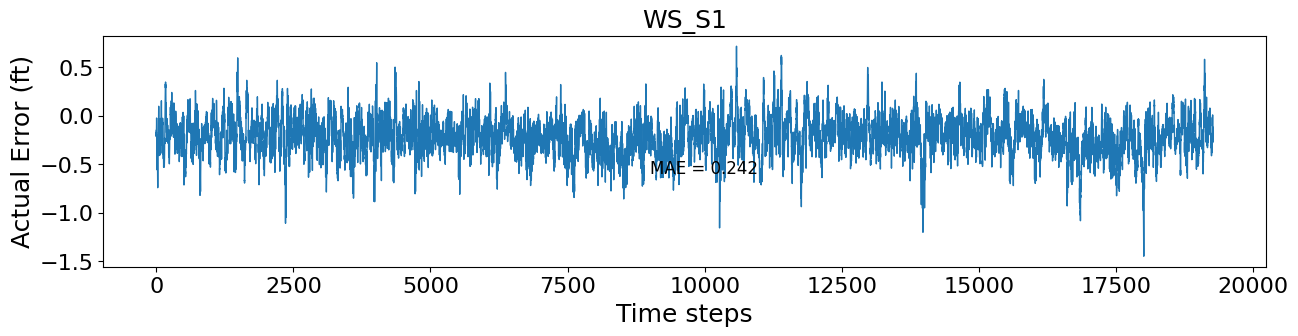

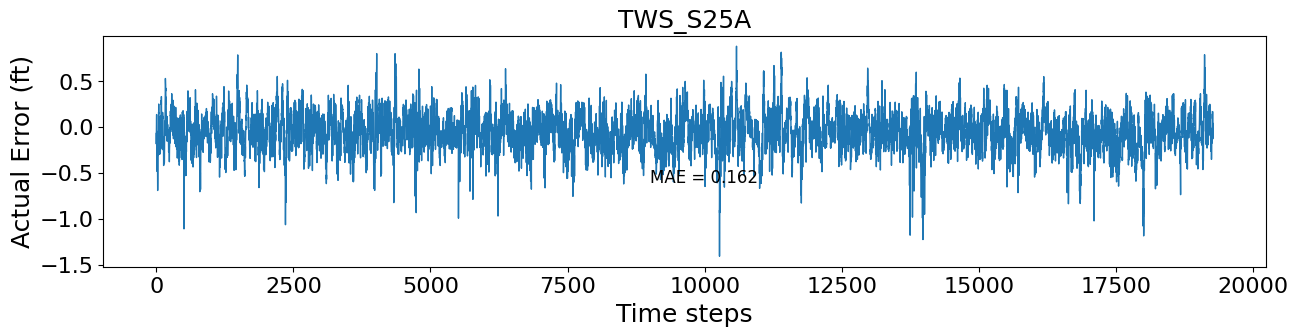

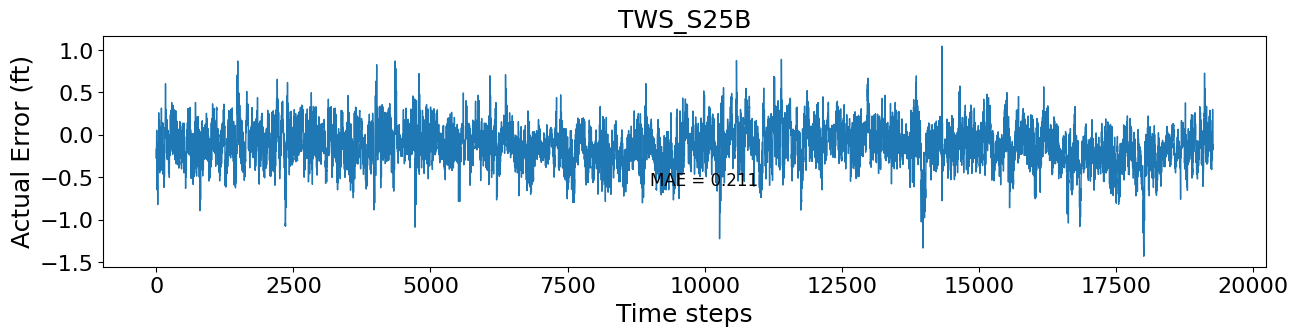

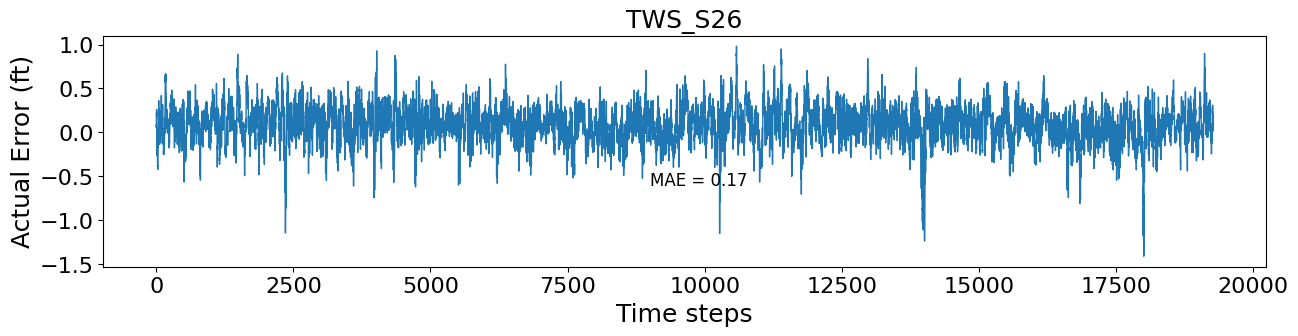

In [11]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [12]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
1352
(19268,)
434
(19268,)
1106
(19268,)
503


In [13]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
22
(19268,)
99
(19268,)
103
(19268,)
363


In [14]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
1330
(19268,)
335
(19268,)
1003
(19268,)
140
